In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Caminho do dataset
caminho_dataset = r"C:/Users/matbm/OneDrive/Documents/Faculdade-Matheus/TCC/data/dataset_reorganizado"

# Configurações principais
tamanho_imagem = (128, 128)
batch_size = 32
num_classes = 5

In [2]:
def carregar_datasets():
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{caminho_dataset}/train",
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=tamanho_imagem,
        shuffle=True,
        seed=123,
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=f"{caminho_dataset}/test",
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=tamanho_imagem,
        shuffle=False,
    )

    # Otimização do pipeline de dados
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset, test_dataset

# 🔹 Carregar os datasets
train_dataset, test_dataset = carregar_datasets()


Found 26447 files belonging to 5 classes.
Found 6614 files belonging to 5 classes.


In [3]:
def criar_modelo():
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(tamanho_imagem[0], tamanho_imagem[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Congelar modelo pré-treinado

    inputs = tf.keras.Input(shape=(128, 128, 3))
    x = tf.keras.layers.Rescaling(1./255)(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# 🔹 Criar modelo
model = criar_modelo()

In [7]:
# 🔹 Definir base_model primeiro
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # 🔥 Inicialmente congelado

# 🔹 Criar modelo utilizando base_model
inputs = tf.keras.Input(shape=(128, 128, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)  
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# 🔹 Função para treinar o modelo congelado
def treinar_modelo(model, train_dataset, test_dataset):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]

    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,
        callbacks=callbacks
    )
    return history

# 🔹 Treinar modelo corretamente
history = treinar_modelo(model, train_dataset, test_dataset)

# 🔹 Função de fine-tuning, agora com base_model corretamente referenciado
def fine_tuning(model, train_dataset, test_dataset, base_model, callbacks):
    base_model.trainable = True  # 🔥 Descongelar EfficientNetB0
    
    # 🔹 Descongelar apenas as últimas 30 camadas
    for layer in base_model.layers[:-30]:  
        layer.trainable = False  

    # 🔹 Recompilar modelo com taxa de aprendizado menor
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 🔹 Treinar modelo refinado (Fine-Tuning)
    history_fine = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=10,  
        callbacks=callbacks  # 🔹 Agora `callbacks` está sendo passado corretamente
    )
    
    return history_fine

# 🔹 Definir callbacks antes de chamar Fine-Tuning
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# 🔹 Executar Fine-Tuning corretamente, passando `callbacks` como argumento
history_fine = fine_tuning(model, train_dataset, test_dataset, base_model, callbacks)



Epoch 1/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 265s 308ms/step - accuracy: 0.2580 - loss: 1.4369 - val_accuracy: 0.2690 - val_loss: 1.4055 - learning_rate: 1.0000e-04
Epoch 2/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 231s 279ms/step - accuracy: 0.2786 - loss: 1.4090 - val_accuracy: 0.2481 - val_loss: 1.4037 - learning_rate: 1.0000e-04
Epoch 3/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 230s 278ms/step - accuracy: 0.2847 - loss: 1.4041 - val_accuracy: 0.2844 - val_loss: 1.4011 - learning_rate: 1.0000e-04
Epoch 4/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 230s 278ms/step - accuracy: 0.2888 - loss: 1.3998 - val_accuracy: 0.3627 - val_loss: 1.3968 - learning_rate: 1.0000e-04
Epoch 5/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 235s 284ms/step - accuracy: 0.2931 - loss: 1.3965 - val_accuracy: 0.3237 - val_loss: 1.3951 - learning_rate: 1.0000e-04
Epoch 6/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 230s 278ms/step - accuracy: 0.2926 - loss: 1.3948 - val_accuracy: 0.3550 - val_loss: 1.3916 - learning_rate: 1.0000e-04
Epoch 7/10
827/827 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<Figure size 700x700 with 0 Axes>

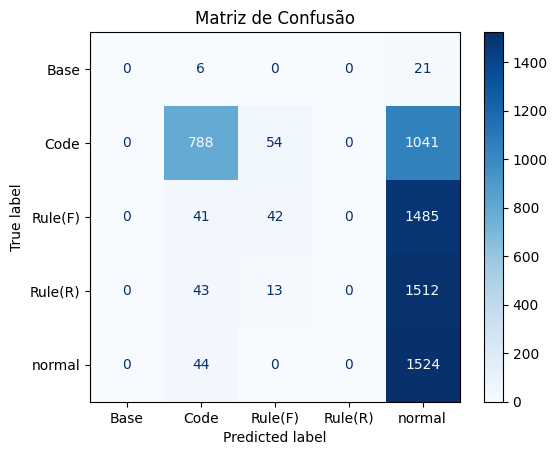


Relatório de Classificação:

              precision    recall  f1-score   support

        Base       0.00      0.00      0.00        27
        Code       0.85      0.42      0.56      1883
     Rule(F)       0.39      0.03      0.05      1568
     Rule(R)       0.00      0.00      0.00      1568
      normal       0.27      0.97      0.43      1568

    accuracy                           0.36      6614
   macro avg       0.30      0.28      0.21      6614
weighted avg       0.40      0.36      0.27      6614



c:\Users\matbm\OneDrive\Documents\Faculdade-Matheus\TCC\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\matbm\OneDrive\Documents\Faculdade-Matheus\TCC\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\matbm\OneDrive\Documents\Faculdade-Matheus\TCC\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

In [8]:
def avaliar_modelo(model, test_dataset):
    y_true, y_pred = [], []

    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Base", "Code", "Rule(F)", "Rule(R)", "normal"])

    plt.figure(figsize=(7,7))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusão')
    plt.show()

    print("\nRelatório de Classificação:\n")
    print(classification_report(y_true, y_pred, target_names=["Base", "Code", "Rule(F)", "Rule(R)", "normal"]))

# 🔹 Avaliar modelo
avaliar_modelo(model, test_dataset)


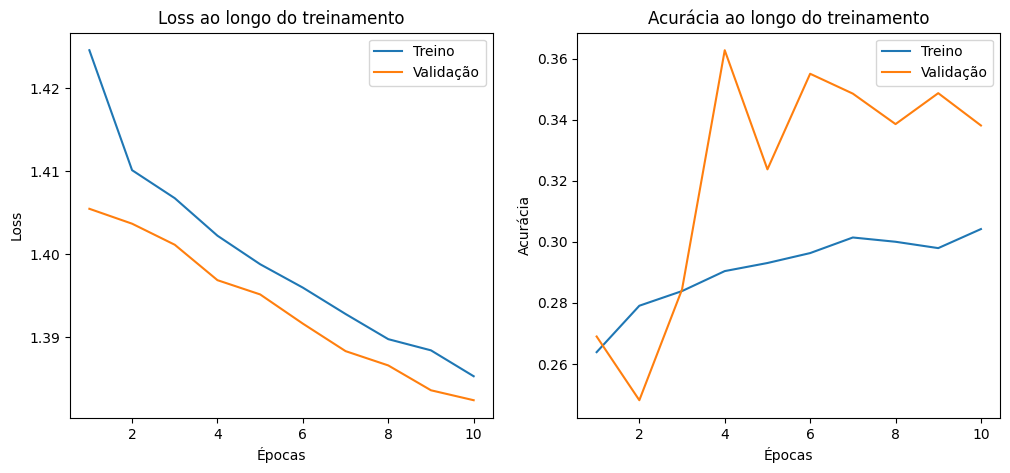

In [9]:
import matplotlib.pyplot as plt

# Função para plotar loss e acurácia
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Treino')
    plt.plot(epochs, history.history['val_loss'], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Loss ao longo do treinamento')
    plt.legend()
    
    # Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Treino')
    plt.plot(epochs, history.history['val_accuracy'], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.title('Acurácia ao longo do treinamento')
    plt.legend()
    
    plt.show()

# Chamar a função com os dados do treinamento
plot_training_history(history)
